In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import quad
from scipy.stats import norm, binom
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('SP_historical_PD_data.csv', sep=';')

In [3]:
df.shape

(40, 8)

In [4]:
df.head()

,Year,Total defaults*,Investment-grade defaults,Speculative-grade defaults,Default rate (%),Investment-grade default rate (%),Speculative-grade default rate (%),Total debt outstanding (bil. $)
0,1981,2,0,2,0.15,0.00,0.63,0.06
1,1982,18,2,15,1.22,0.19,4.46,0.90
2,1983,12,1,10,0.77,0.09,2.98,0.37
3,1984,14,2,12,0.93,0.17,3.31,0.36
4,1985,19,0,18,1.13,0.00,4.37,0.31


In [5]:
# Calculate the number of obligors
df['num_of_inv_grades'] = (df['Investment-grade defaults'] / (df['Investment-grade default rate (%)']/100)).round()
df['num_of_spec_grades'] = (df['Speculative-grade defaults'] / (df['Speculative-grade default rate (%)']/100)).round().astype(int)
df['num_of_total_grades'] = (df['Total defaults*'] / (df['Default rate (%)']/100)).round().astype(int)

# Fill-out the missing values in num_of_inv_grades column with the difference between num_of_total_grades and num_of_spec_grades
df['num_of_inv_grades'] = np.where(df['num_of_inv_grades'].isna(), df['num_of_total_grades'] - df['num_of_spec_grades'], df['num_of_inv_grades']).astype(int)

In [6]:
def p_g(X_g, w_g, gamma_g):
    """
    Calculates the success probability of a Bernoulli trial.

    Parameters:
        X_g (float): Input value.
        w_g (float): Parameter 'w_g'.
        gamma_g (float): Parameter 'gamma_g'.

    Returns:
        float: Result of p_g(X_g).
    """
    modified_result = norm.cdf((gamma_g - w_g * X_g) / np.sqrt(1 - w_g**2))

    return modified_result

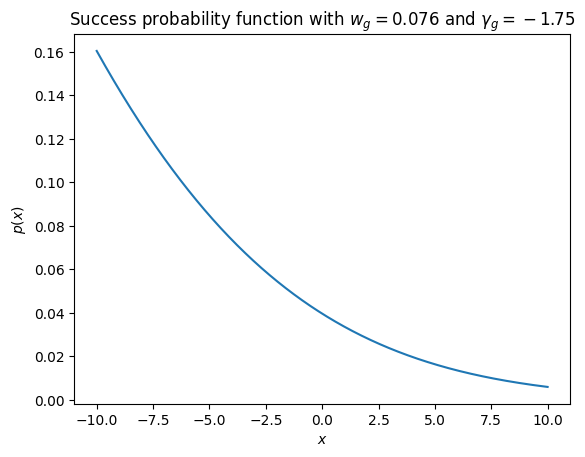

In [7]:
# A plot for p_g(X_g) with w_g = 0.076 and gamma_g = -1.75
import matplotlib.pyplot as plt

X_values = np.linspace(-10, 10, 1000)
p_g_values = p_g(X_values, w_g=0.07602889962521624, gamma_g=-1.7498743361043698)

plt.plot(X_values, p_g_values)
plt.title(r'Success probability function with $w_g = 0.076$ and $\gamma_g = -1.75$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.show()

In [8]:
def calculate_my_likelihood(d_g, n_g, p_g, prob_dens_func, w_g, gamma_g):
    """
    Numerically calculates the value of L(d_g) based on the given formula.

    Parameters:
        d_g (int): Value of d_g.
        n_g (int): Value of n_g.
        p_g (callable): The p_g function representing the probability density function.
        prob_dens_func (callable): The pdf_g function representing the probability density function.
        w_g (float): Parameter 'w_g'.
        gamma_g (float): Parameter 'gamma_g'.

    Returns:
        float: Numerical approximation of the integral.
    """
    
    integrand = lambda x: binom.pmf(d_g, n_g, p_g(x, w_g, gamma_g)) * prob_dens_func(x)
    
    result, _ = quad(integrand, -5, 5)
    
    return result

In [9]:
# An example for the calculation of the likelihood
test_d_g = 5
test_n_g = 100
prob_dens_func = norm.pdf
test_w_g = 0.2
test_gamma_g = -1.6449

L_result = calculate_my_likelihood(test_d_g, test_n_g, p_g, prob_dens_func, test_w_g, test_gamma_g)
print(f"The value of L(d) for d = {test_d_g} and n = {test_n_g} is {L_result}")

The value of L(d) for d = 5 and n = 100 is 0.1292128248331851


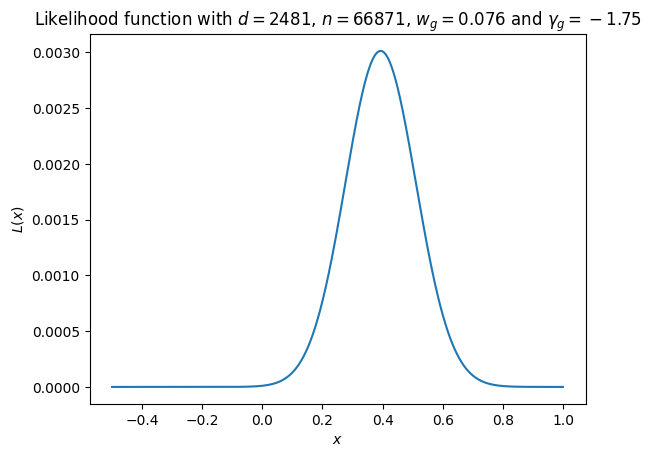

The value of L(d) for x = -0.5 is 3.8226587563618906e-16
The value of L(d) for x = -0.4 is 2.1750989988242528e-13
The value of L(d) for x = -0.3 is 5.6940763795595115e-11
The value of L(d) for x = -0.2 is 6.9032005474286545e-09
The value of L(d) for x = -0.1 is 3.9011936524475226e-07
The value of L(d) for x = 0 is 1.0343935588616072e-05
The value of L(d) for x = 0.1 is 0.00012951537757916585
The value of L(d) for x = 0.2 is 0.0007707160958007588
The value of L(d) for x = 0.3 is 0.002193712487410678
The value of L(d) for x = 0.4 is 0.003005633217919668
The value of L(d) for x = 0.5 is 0.001994831227527262
The value of L(d) for x = 0.6 is 0.0006453824410178764
The value of L(d) for x = 0.7 is 0.00010241881953995435
The value of L(d) for x = 0.8 is 8.022111026123481e-06
The value of L(d) for x = 0.9 is 3.1204860229681983e-07
The value of L(d) for x = 1 is 6.065163781951116e-09


In [10]:
# A plot for the likelihood function with w_g = 0.076 and gamma_g = -1.75
d_for_plot = 2481
n_for_plot = 66871
w_for_plot = 0.07602889962521624
gamma_for_plot = -1.7498743361043698

likelihood_func = lambda x: binom.pmf(d_for_plot, n_for_plot, p_g(x, w_for_plot, gamma_for_plot)) * norm.pdf(x)

x_values = np.linspace(-0.5, 1, 1000)
L_values = [likelihood_func(x) for x in x_values]

plt.plot(x_values, L_values)
plt.title(r'Likelihood function with $d = 2481$, $n = 66871$, $w_g = 0.076$ and $\gamma_g = -1.75$')
plt.xlabel(r'$x$')
plt.ylabel(r'$L(x)$')
plt.show()

# Print the values of the likelihood function for -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 and 1
for x in [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(f"The value of L(d) for x = {x} is {likelihood_func(x)}")

In [11]:
def calculate_likelihood_ts(d_g, n_g, p_g, pdf_g, w_g, gamma_g):
    """
    Numerically calculates the time series value of L(d_g) based on the given formula by multiply for each date.

    Parameters:
        d_g (pd.Series): Time series for d_g.
        n_g (pd.Series): Time series for n_g.
        p_g (callable): The p_g function representing the probability density function.
        pdf_g (callable): The pdf_g function representing the probability density function.
        w_g (float): Parameter 'w_g'.
        gamma_g (float): Parameter 'gamma_g'.

    Returns:
        float: Numerical approximation of the integral.
    """
    integrand = lambda x: np.prod(binom.pmf(d_g, n_g, p_g(x, w_g, gamma_g)) * pdf_g(x))
    
    result, _ = quad(integrand, -5, 5)
    
    return result

In [12]:
# Test the calculate_likelihood_ts function
test_d_series = pd.Series([5, 8, 12, 4, 9])
test_n_series = pd.Series([100, 194, 199, 113, 97])
pd_list = test_d_series / test_n_series
test_ttc_pd = pd_list.mean()
test_gamma = stats.norm.ppf(test_ttc_pd)

L_result = calculate_likelihood_ts(test_d_series, test_n_series, p_g, norm.pdf, test_w_g, test_gamma)
print(f"The value of L(d) for d = {test_d_series.tolist()} and n = {test_n_series.tolist()} is {L_result}")

The value of L(d) for d = [5, 8, 12, 4, 9] and n = [100, 194, 199, 113, 97] is 7.845116837086311e-08


In [13]:
# Check calculate_likelihood_ts gives the same result as calculate_my_likelihood if we sum the d_g and n_g values
d_g_sum = test_d_series.sum()
n_g_sum = test_n_series.sum()

L_result = calculate_my_likelihood(d_g_sum, n_g_sum, p_g, norm.pdf, test_w_g, test_gamma)
print(f"The value of L(d) for d = {d_g_sum} and n = {n_g_sum} is {L_result}")

The value of L(d) for d = 38 and n = 703 is 0.023596907873853223


### To-do: Fix this bug that cause the difference between the results of the two functions
It is not a bug because the binom constant can be different for the two functions.

In [14]:
# Test the calculate_likelihood_ts function gives the same result as calculate_my_likelihood for 1 observation
test_d_series = pd.Series([5])
test_n_series = pd.Series([100])

L_result = calculate_likelihood_ts(test_d_series, test_n_series, p_g, norm.pdf, test_w_g, test_gamma)
print(f"The value of L(d) for d = {test_d_series.tolist()} and n = {test_n_series.tolist()} is {L_result}")

L_result = calculate_my_likelihood(test_d_series.sum(), test_n_series.sum(), p_g, norm.pdf, test_w_g, test_gamma)
print(f"The value of L(d) for d = {test_d_series.sum()} and n = {test_n_series.sum()} is {L_result}")

The value of L(d) for d = [5] and n = [100] is 0.12877403928856326
The value of L(d) for d = 5 and n = 100 is 0.12877403928856326


In [15]:
weight_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

for weight in weight_list:
    L_result = calculate_likelihood_ts(test_d_series, test_n_series, p_g, norm.pdf, weight, test_gamma)
    print(f"The value of L(d) is {L_result} with weight {weight}")

The value of L(d) is 0.1586882457044726 with weight 0.1
The value of L(d) is 0.14414812274968142 with weight 0.15
The value of L(d) is 0.12877403928856326 with weight 0.2
The value of L(d) is 0.11406393875773152 with weight 0.25
The value of L(d) is 0.10062794463946392 with weight 0.3
The value of L(d) is 0.08859873046842222 with weight 0.35
The value of L(d) is 0.07789498649012586 with weight 0.4
The value of L(d) is 0.06835819594296397 with weight 0.45


In [16]:
# Test the calculate_likelihood_ts function
test_d_series = pd.Series([5, 8, 12, 4, 9])
test_n_series = pd.Series([100, 194, 199, 113, 97])

# MLE condition and initial guess
w_g_initial = 0.23
gamma_g_initial = 1.23

# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_likelihood_ts(test_d_series, test_n_series, p_g, norm.pdf, params[0], params[1])

initial_guess = [w_g_initial, gamma_g_initial]
# Bounds for the weight parameter
bounds = [(0, 1), (-np.inf, np.inf)]
result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight[0]}")
print(f"The optimal gamma parameter is {optimal_weight[1]}")

The optimal weight parameter is 0.0
The optimal gamma parameter is -1.606740624762165


In [17]:
# Test the calculate_likelihood_ts function
test_d_series = pd.Series([5, 8, 12, 4, 9, 10, 15, 20])
test_n_series = pd.Series([100, 194, 199, 113, 97, 140, 210, 303])

result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight[0]}")
print(f"The optimal gamma parameter is {optimal_weight[1]}")

The optimal weight parameter is 0.0
The optimal gamma parameter is -1.544736976236119


# MLE example for a slice of the historical time series

In [18]:
# MLE example
short_d_g = df['Total defaults*'].iloc[10:15]
short_n_g = df['num_of_total_grades'].iloc[10:15]
gamma = stats.norm.ppf(df['Default rate (%)'].iloc[10:15].mean() / 100)

# MLE condition and initial guess
initial_guess = [0.23]
bounds = [(0, 1)]

# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_likelihood_ts(short_d_g, short_n_g, p_g, norm.pdf, params[0], gamma)

result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight}")

The optimal weight parameter is [0.04905469]


In [19]:
# MLE example
short_d_g = df['Total defaults*'].iloc[10:15]
short_n_g = df['num_of_total_grades'].iloc[10:15]
gamma = stats.norm.ppf(df['Default rate (%)'].iloc[10:15].mean() / 100)

# MLE condition and initial guess
w_g_initial = 0.23
gamma_g_initial = 1.23

# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_likelihood_ts(short_d_g, short_n_g, p_g, norm.pdf, params[0], params[1])

initial_guess = [w_g_initial, gamma_g_initial]
# Bounds for the weight parameter
bounds = [(0, 1), (-np.inf, np.inf)]
result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powel


# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight}")

The optimal weight parameter is [0.23 1.23]


# MLE for the whole historical time series

In [20]:
TTC_PD = df['Default rate (%)'].mean() / 100
print(f"The TTC PD is {TTC_PD}")

The TTC PD is 0.014767500000000003


In [21]:
d_g = df['Total defaults*']
n_g = df['num_of_total_grades']
gamma_g = stats.norm.ppf(df['Default rate (%)'].mean() / 100)

# MLE condition and initial guess
initial_guess = 0.23
bounds = [(0, 1)]

# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_likelihood_ts(d_g, n_g, p_g, norm.pdf, params[0], gamma_g)

result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight}")

The optimal weight parameter is [0.23]


Value of objective function not changing with the weight parameter, so the MLE is not working properly

# We can aggregate the $d_{g}$ and $n_{g}$ values because the likelihood function is additive in these parameters

In [22]:
d_total_sum = df['Total defaults*'].sum()
n_total_sum = df['num_of_total_grades'].sum()

print(f"The sum of d_g is {d_total_sum}")
print(f"The sum of n_g is {n_total_sum}")

The sum of d_g is 3098
The sum of n_g is 202644


In [23]:
d_spec_sum = df['Speculative-grade defaults'].sum()
n_spec_sum = df['num_of_spec_grades'].sum()
pd_spec_average = df['Speculative-grade default rate (%)'].mean() / 100
gamma_spec = stats.norm.ppf(pd_spec_average)

print(f"The sum of d_g is {d_spec_sum}")
print(f"The sum of n_g is {n_spec_sum}")
print(f"The average PD is {round(pd_spec_average,5)}")
print(f"The gamma parameter is {round(gamma_spec, 5)}")

The sum of d_g is 2481
The sum of n_g is 66871
The average PD is 0.04007
The gamma parameter is -1.74987


In [24]:
w_g_from_MM = 0.07602889962521624

In [25]:
print(binom.pmf(d_g_sum, n_g_sum, p_g(0, w_g_from_MM, gamma_spec)))

0.011763672840221083


In [26]:
calculate_my_likelihood(d_g_sum, n_g_sum, p_g, norm.pdf, 0.07602889962521624, gamma_g)

8.842263536915088e-08

In [27]:
# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_my_likelihood(d_spec_sum, n_spec_sum, p_g, norm.pdf, params[0], params[1])

w_g_initial = 0.07602889962521624
gamma_g_initial = gamma_g
initial_guess = [w_g_initial, gamma_g_initial]
# Bounds for the weight parameter
bounds = [(0, 1), (-np.inf, np.inf)]
result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_parameters = result.x
print(f"The optimal weight parameter is {optimal_parameters[0]}")
print(f"The optimal gamma parameter is {optimal_parameters[1]}")

The optimal weight parameter is 0.0
The optimal gamma parameter is -1.785371795774377


In [28]:
d_total_sum = df['Total defaults*'].sum()
n_total_sum = df['num_of_total_grades'].sum()

# Function to be minimized in weight parameter
objective_function = lambda params: -calculate_my_likelihood(d_total_sum, n_total_sum, p_g, norm.pdf, params[0], params[1])

w_g_initial = 0.17
gamma_g_initial = -1.43
initial_guess = [w_g_initial, gamma_g_initial]
# Bounds for the weight parameter
bounds = [(0, 1), (-np.inf, np.inf)]
result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_parameters = result.x
print(f"The optimal weight parameter is {optimal_parameters[0]}")
print(f"The optimal gamma parameter is {optimal_parameters[1]}")

The optimal weight parameter is 0.0
The optimal gamma parameter is -2.162537925116004
